In [1]:
import numpy as np

import torch
import torch.nn as nn

# 1. Visualization of the Loss Surface

## 1.1. Load Model and Data

In [2]:
# Import utils from a specific defense
from defenses.loader import base_loader # Base Loader
from defenses.model import get_model # Base Model

In [3]:
# Set Settings
MODEL = "PRN18"
DATA_NAME = "CIFAR10"
SAVE_PATH = "./ckp/Fast.pth"

In [4]:
# Set Train, Test Loader
train_loader, test_loader = base_loader(data_name=DATA_NAME,
                                        shuffle_train=True)

# Set Model
model = get_model(name=MODEL, num_classes=10).cuda()
model.load_state_dict(torch.load(SAVE_PATH))
model = model.cuda().eval()

Files already downloaded and verified
Files already downloaded and verified
Data Loaded!
Train Data Length : 50000
Test Data Length : 10000
PRN18 is loaded.


In [5]:
# Get images and labels.
images, labels = iter(test_loader).next()
images, labels = images.cuda(), labels.cuda()

## 1.2. Generate Adversarial Images

In [6]:
import torchattacks
from torchattacks import FGSM

In [7]:
# Generate adversarial images
atk = FGSM(model, eps=8/255)
adv_images = atk(images, labels)

In [8]:
# Adversarial Robustness against FGSM
atk.save(data_loader=test_loader, save_path=None, verbose=True)

## 1.3. Get Directions and Draw

In [9]:
import torchhk
from torchhk.vis import cal_perturb, plot_perturb_plt

In [10]:
# Pick one image from the batch.
j = 4
adv_direction = adv_images[j] - images[j]
rand_direction = 8/255*torch.rand_like(images[j])

In [11]:
# Generate the loss value and predictions for each grid value
rx, ry, zs, colors = cal_perturb(model=model,
                                 image=images[j], label=labels[j],
                                 vec_x=adv_direction, vec_y=rand_direction,
                                 range_x=(0,1), range_y=(0,1), 
                                 grid_size=30,
                                 loss=nn.CrossEntropyLoss(reduction='none'),
                                )

In [12]:
# Check classes in the adversarial direction.
print("Classes in the adversarial direction", set(colors.reshape(-1).tolist()))

Classes in the adversarial direction {2, 6}


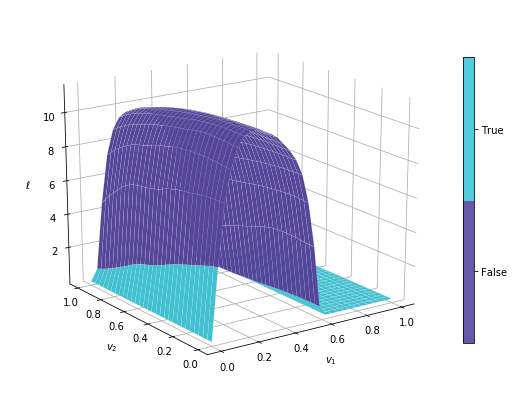

In [13]:
# Draw the loss surface
plot_perturb_plt(rx, ry, zs, colors==colors[0][0],
                 z_by_loss=True, color_by_loss=False,
                 color=["#6858ab", "#53cddb"],
                 min_value=None, max_value=None,
                 title=None, width=8, height=7, linewidth = 0.1,
                 x_ratio=1, y_ratio=1, z_ratio=1,
                 edge_color='#f2fafb',
                 colorbar_yticklabels=["False", "True"],
                 pane_color=(1.0, 1.0, 1.0, 0.0),
                 tick_pad_x=0, tick_pad_y=0, tick_pad_z=1.5,
                 xticks=None, yticks=None, zticks=None,
                 xlabel=r'$v_1$', ylabel=r'$v_2$', zlabel=r'$\ell$',
                 view_azimuth=235, view_altitude=20,
                 light_azimuth=0, light_altitude=20, light_exag=0)

# 2. Distortion

In [14]:
# Funtion for checking the number of times the precition changes.
def diff_num(arr):
    num = 0
    pre = arr[0]
    for item in arr :
        if item != pre :
            num = num + 1
            pre = item
    return num

In [15]:
m=100 # Number of samples in adversarial direction.
batch_size = len(images)

# Calculate distortion d.
clean_correct = []
adv_correct = []
diff = []

for j in range(batch_size):
    # Generate adversarial images.
    fgsm = FGSM(model, eps=8/255)
    adv_images = fgsm(images[j:j+1], labels[j:j+1])[0]
    pert = adv_images - images[j]

    # Generate Checkpoints.
    X = []
    for k in range(m+1) :
        X.append(images[j]+(k*1.0/m)*pert)

    # Check prediction and distortion.
    outputs = model(torch.stack(X))
    _, pre = torch.max(outputs.data, 1)

    clean_correct.append(labels[j] == pre[0])
    adv_correct.append(labels[j] == pre[-1])

    diff.append(diff_num(pre.cpu().numpy()))

distort = []
total = 0.0
for j, d in enumerate(diff):
    # Check clean images and adversarial images are correctly classified.
    right =  clean_correct[j]*adv_correct[j]
    if right == 1:
        total += 1
        distort.append(d)

print("Distortion: %2.2f %%"%(np.sum(np.array(distort) > 0) / total))

Distortion: 1.00 %
